In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

from ckine.model import runIL2simple

### Initial assumptions

To review, we've been assuming (1) that binding occurs identically in the endosome as compared to the surface, (2) constant rate of receptor expression, (3) active receptor complexes are endocytosed at a higher rate, and (4) active complexes in the endosome still have signaling capacity. Here, we've adjusted the model to make all binding 5-fold weaker in the endosome as compared to the surface. We're also using our fit expression levels of IL2Ra, IL2Rb, and gc for the YT-1 cell line (3.9, 0.7, 1.7 receptors/min/cell, respectively). The binding rate parameters used here are from fitting using our older endosome binding assumption, but we're in the process of running fitting again to update these. I doubt the results here will change meaningfully. We're also adding a sigmoidal relationship between number of active complexes and STAT5 activation like we discussed. However, we haven't yet run the fitting with this, and so the values here are all proportional to active receptor complexes.

In [2]:
def dRespon(input, CD25=1.0):
    """ Calculate an IL2 dose response curve. """
    ILs = np.logspace(-3.0, 3.0)
    activee = np.array([runIL2simple(input, ii, CD25) for ii in ILs])
        
    return ILs, activee

def IC50global(x, y):
    """ Calculate half-maximal concentration w.r.t. wt. """
    return np.interp(20.0, y, x)

changesA = np.logspace(-2, 1, num=20)
changesB = np.array([1.0, 2.0, 5.0, 10.0, 20.0])
output = np.zeros((changesA.size, changesB.size))

for i, itemA in enumerate(changesA):
    for j, itemB in enumerate(changesB):
        ILs, BB = dRespon([itemA, itemB, 5.0])
        output[i, j] = IC50global(ILs, BB)

### Exchanging IL2Rb for IL2Ra affinity in CD25+ cells

A reminder this is using our inferred receptor expression levels from working with the CD25+ YT-1 cells. On the x-axis we're varying IL2Ra affinity (lower values mean tighter binding). The colors indicate differing IL2Rb affinities (again, higher values indicate weaker binding). The y-axis is the IL2 concentration at which you reach half-maximal activation in the wild-type cells (i.e. ~20 active receptor complexes). The black line shows the level that corresponds to wild type.

As expected, this shows there is indeed a trade-off, and one can reduce the affinity to IL2Rb after increasing it to IL2Ra. For example, the green line shows a 10X increase in IL2Ra affinity allows a 5X decrease in IL2Rb affinity to preserve the same threshold.

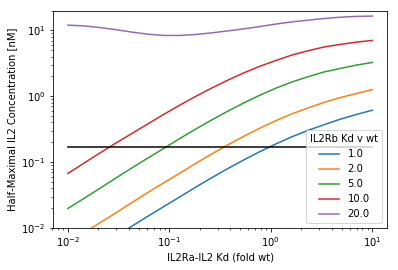

In [3]:
for ii in range(output.shape[1]):
    plt.loglog(changesA, output[:, ii], label=str(changesB[ii]));

plt.loglog([0.01, 10.], [0.17, 0.17], 'k-')
plt.ylabel('Half-Maximal IL2 Concentration [nM]');
plt.xlabel('IL2Ra-IL2 Kd (fold wt)');
plt.ylim((0.01, 20))
plt.legend(title="IL2Rb Kd v wt");

### Exchange does change other IL2 response metrics

However, exactly how much you adjust each affinity is dependent upon how you quantify IL2 response. The example I gave is plotted below, where you can see you have the same half-maximal concentration, but level of maximal activation is now lower.

I know we also discussed looking at how fast ligand is consumed in cases such as this. That's very straightforward to calculate within the model but I've left anything about ligand consumption out for now.

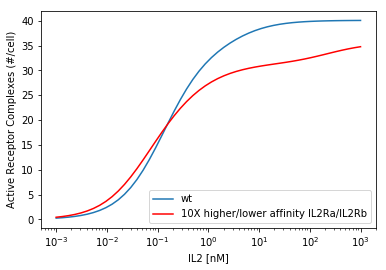

In [4]:
wt = dRespon([1.0, 1.0, 5.0])
ten = dRespon([0.1, 5.0, 5.0])

plt.semilogx(wt[0], wt[1], label="wt");
plt.semilogx(ten[0], ten[1], 'r', label="10X higher/lower affinity IL2Ra/IL2Rb");
plt.ylabel('Active Receptor Complexes (#/cell)');
plt.xlabel('IL2 [nM]');
plt.legend();

### IL2Rb affinity adjustment with variable CD25 expression

A second concern we discussed is separating CD25+/CD25- cells. Here, the lines indicate cells with reduced CD25 expression (relative to the cells above), then the x-axis is IL2Rb affinity. The y-axis is the same half-maximal activation threshold. Because the lines remain similarly spaced, this seems to indicate adjusting the IL2Rb affinity doesn't give you any better/worse discrimination between CD25+/CD25- cells. The difference in half maximal concentration for 10% CD25 and no CD25 is less than 2-fold. **Note this is for wild-type IL2Ra affinity.**

In [5]:
changesA = np.logspace(-1, 1.5, num=20)
changesB = np.array([0.0, 0.1, 0.25, 0.5, 1.0])
output = np.zeros((changesA.size, changesB.size))

for i, itemA in enumerate(changesA):
    for j, itemB in enumerate(changesB):
        ILs, BB = dRespon([1.0, itemA, 5.0], CD25=itemB)
        output[i, j] = IC50global(ILs, BB)

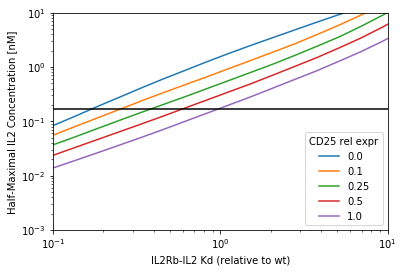

In [6]:
for ii in range(output.shape[1]):
    plt.loglog(changesA, output[:, ii], label=str(changesB[ii]));

plt.loglog([0.1, 10.], [0.17, 0.17], 'k-')
plt.ylabel('Half-Maximal IL2 Concentration [nM]');
plt.xlabel('IL2Rb-IL2 Kd (relative to wt)');
plt.ylim((0.001, 10))
plt.xlim((0.1, 10))
plt.legend(title="CD25 rel expr");

### Same plot, with 10X higher IL2Ra affinity

Here is the same plot, but with a 10-fold higher IL2Ra affinity. Now there's much better separation of the cell populations—almost 100-fold difference in half-max for CD25+ vs CD25-, and just under 10-fold for 25% levels of CD25. Again IL2Rb affinity doesn't influence the level of specificity between cell populations. Note that modulating IL2Rb affinity could still have benefits in ligand consumption.

In [7]:
for i, itemA in enumerate(changesA):
    for j, itemB in enumerate(changesB):
        ILs, BB = dRespon([0.1, itemA, 5.0], CD25=itemB)
        output[i, j] = IC50global(ILs, BB)

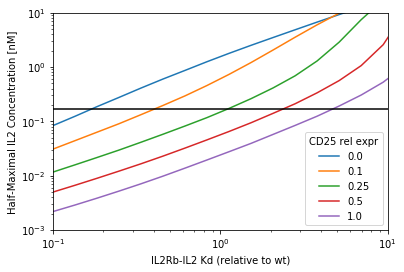

In [8]:
for ii in range(output.shape[1]):
    plt.loglog(changesA, output[:, ii], label=str(changesB[ii]));

plt.loglog([0.1, 10.], [0.17, 0.17], 'k-')
plt.ylabel('Half-Maximal IL2 Concentration [nM]');
plt.xlabel('IL2Rb-IL2 Kd (relative to wt)');
plt.ylim((0.001, 10))
plt.xlim((0.1, 10))
plt.legend(title="CD25 rel expr");